In [123]:
########## Libraries #########
import torch 
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns 
import json
import numpy as np
from sklearn.cluster import AgglomerativeClustering
##############################


# Read embeddings and Entity information

In [124]:
############# read embedding tensors ##############
############# substitute the file name to generate intended graph #################
bert_embedding = torch.load('pt_files/bert_ent.pt').cpu().numpy()
simkgc_embedding = torch.load('pt_files/entity_tensor_npnd.pt').cpu().numpy()
transe_embedding = torch.load('transe_embedding.tar')['model_state_dict']['entities_emb.weight'].cpu().numpy()
############# read entity information ############
df_ent_info = pd.read_csv("string_matching_concept.csv", index_col=0)
df_ent_info = df_ent_info.assign(bert_embedding = list(bert_embedding))
df_ent_info = df_ent_info.assign(simkgc_embedding = list(simkgc_embedding))

df_ent_info.tail()

df_ent_info = df_ent_info[df_ent_info["concept_class"].isin([0,1,4,6,11,12])]

# Read Commonsense Information (ent_dom.json, source: CAKE)

In [125]:
####### Convert a set of concepts to an array ########
def dom_set2dom_arr(dom_list, dom_cnt = 88):
    dom_arr = []
    for i in range(dom_cnt):
        if i in dom_list:
            dom_arr.append(1)
        else:
            dom_arr.append(0)
    return np.array(dom_arr)

####### Read ent_dom information ############
f = open('ent_dom.json')
ent_dom = json.load(f)
new_ent_dom_dict = {}
for ent in ent_dom:
    new_ent_dom_dict[ent] = dom_set2dom_arr(ent_dom[ent])
    

# Get clustering labels based on concept set (This Step can now be omitted as we have labelled the data)
Originally, there is no clear label on each entity, the hierachical clustering is adopted for assigning concepts

In [126]:
########## Get clustering labels based on concept set ###########
X = np.array(list(new_ent_dom_dict.values()))
clustering = AgglomerativeClustering(n_clusters=10).fit(X)
clustered_labels = clustering.labels_

# Concatenate Two Dataframes

In [127]:
df_label = pd.DataFrame().assign(label=clustered_labels, entity_id=list(new_ent_dom_dict.keys()))
df_label.head()

### filter out entity without concept

df_ent_info_full = pd.merge(df_ent_info, df_label, on="entity_id")
df_ent_info_full["label"] = df_ent_info_full["label"].astype(str)
df_ent_info_full["concept_class"] = df_ent_info_full["concept_class"].astype(str)
df_ent_info_full.head()

,entity_id,entity,entity_desc,concept_class,concept_name,bert_embedding,simkgc_embedding,label
0,/m/06cx9,Republic,"""A republic is a form of government in which p...",6,states/area/city,"[-0.0014653528, 0.0221879, 0.016507665, -0.001...","[-0.0011605294, -0.012015183, -0.0422471, 0.00...",3
1,/m/017dcd,Mighty Morphin Power Rangers,"""Mighty Morphin Power Rangers is an American l...",1,film/comedy,"[-0.033379123, -0.04066237, 0.061522704, 0.020...","[0.014220073, -0.008950524, 0.018459607, -0.03...",1
2,/m/06v8s0,Wendee Lee,"""Wendee Lee is an American voice actress. Whil...",0,actor/actress,"[-0.0022833827, -0.022558557, -0.014247492, -0...","[0.024640007, -0.047137074, -0.045656253, -0.0...",2
3,/m/0170z3,American History X,"""American History X is a 1998 American drama f...",1,film/comedy,"[-0.02510499, 0.015907515, 0.025088662, -0.027...","[0.040258605, 0.013997224, -0.092762284, -0.03...",9
4,/m/01sl1q,Michelle Rodriguez,"""Mayte Michelle Rodriguez, simply credited as ...",0,actor/actress,"[0.010183454, -0.03296431, 0.03311149, -0.0228...","[-0.03450175, -0.030905265, -0.022632994, 0.01...",2


In [128]:
from collections import Counter
from torch.utils import data
from typing import Dict, Tuple

Mapping = Dict[str, int]


def create_mappings(dataset_path: str) -> Tuple[Mapping, Mapping]:
    """Creates separate mappings to indices for entities and relations."""
    # counters to have entities/relations sorted from most frequent
    entity_counter = Counter()
    relation_counter = Counter()
    with open(dataset_path, "r") as f:
        for line in f:
            # -1 to remove newline sign
            head, relation, tail = line[:-1].split("\t")
            entity_counter.update([head, tail])
            relation_counter.update([relation])
    entity2id = {}
    relation2id = {}
    for idx, (mid, _) in enumerate(entity_counter.most_common()):
        entity2id[mid] = idx
    for idx, (relation, _) in enumerate(relation_counter.most_common()):
        relation2id[relation] = idx
    return entity2id, relation2id

In [129]:
entity2id, relation2id = create_mappings("fb237_train.txt")
def id2ent(n):
    return (list(entity2id.keys())[list(entity2id.values()).index(n)])
def id2rel(n):
    return (list(relation2id.keys())[list(relation2id.values()).index(n)])

In [130]:
invalid_entity_list = ['/m/01x4x4','/m/01lk31','/m/04z288','/m/09cmq','/m/0dng4','/m/08hbxv',
'/m/01x8f6','/m/037vqt','/m/05k8m5','/m/0hsph','/m/02rxd26','/m/07hn5','/m/047vnfs','/m/0jvq','/m/0lyb_',
'/m/027yjnv','/m/024030']
df_ent_info_full = df_ent_info_full[~df_ent_info_full.entity_id.isin(invalid_entity_list)] 

In [131]:
df_ent_info_full['transe_embedding'] = [transe_embedding[ entity2id[i] ] for i in df_ent_info_full['entity_id']]

In [132]:
df_ent_info_full.head()

,entity_id,entity,entity_desc,concept_class,concept_name,bert_embedding,simkgc_embedding,label,transe_embedding
0,/m/06cx9,Republic,"""A republic is a form of government in which p...",6,states/area/city,"[-0.0014653528, 0.0221879, 0.016507665, -0.001...","[-0.0011605294, -0.012015183, -0.0422471, 0.00...",3,"[0.051347617, -0.1933725, -0.12733337, 0.04318..."
1,/m/017dcd,Mighty Morphin Power Rangers,"""Mighty Morphin Power Rangers is an American l...",1,film/comedy,"[-0.033379123, -0.04066237, 0.061522704, 0.020...","[0.014220073, -0.008950524, 0.018459607, -0.03...",1,"[-0.18852358, 0.19600795, 0.20846891, 0.063680..."
2,/m/06v8s0,Wendee Lee,"""Wendee Lee is an American voice actress. Whil...",0,actor/actress,"[-0.0022833827, -0.022558557, -0.014247492, -0...","[0.024640007, -0.047137074, -0.045656253, -0.0...",2,"[-0.15543821, 0.06153069, 0.2255898, 0.0959760..."
3,/m/0170z3,American History X,"""American History X is a 1998 American drama f...",1,film/comedy,"[-0.02510499, 0.015907515, 0.025088662, -0.027...","[0.040258605, 0.013997224, -0.092762284, -0.03...",9,"[-0.057601884, 0.29463822, 0.10088043, 0.03216..."
4,/m/01sl1q,Michelle Rodriguez,"""Mayte Michelle Rodriguez, simply credited as ...",0,actor/actress,"[0.010183454, -0.03296431, 0.03311149, -0.0228...","[-0.03450175, -0.030905265, -0.022632994, 0.01...",2,"[0.16799483, -0.13306451, -0.018210249, -0.018..."


# PCA on the Results

(2113, 2)
(2113, 2)
(2113, 2)


<AxesSubplot:title={'center':'transe'}>

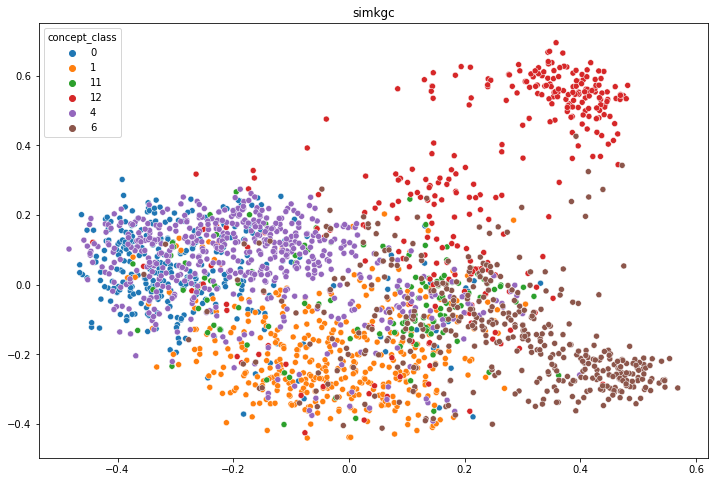

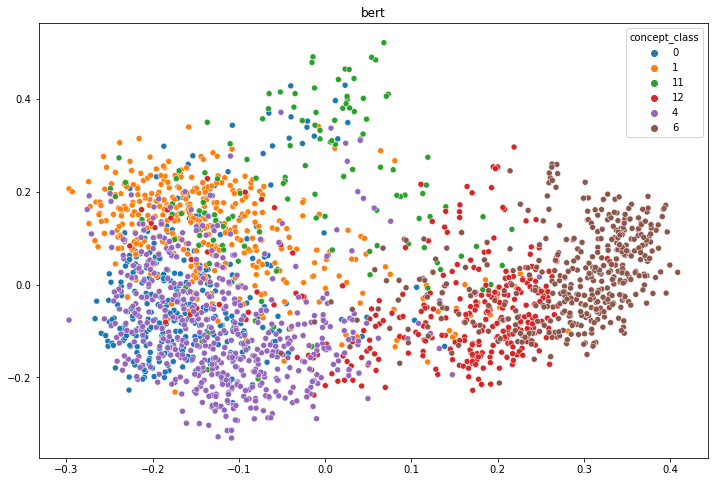

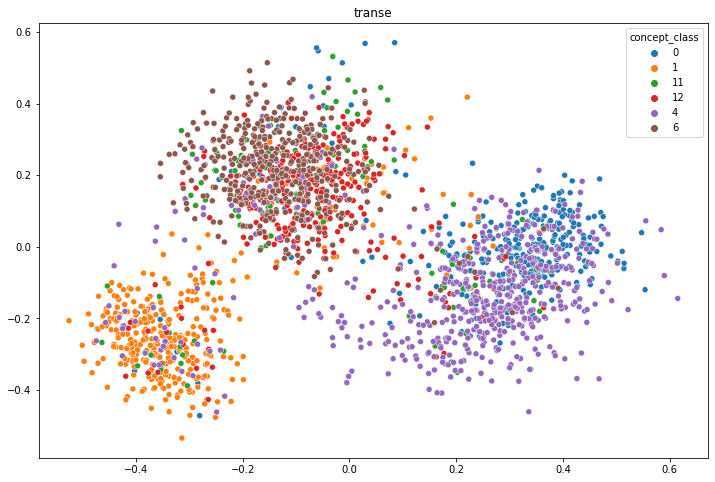

In [133]:

from random import random
from paddle import seed
from sklearn.decomposition import PCA

df_ent_info_sampled = df_ent_info_full.groupby("concept_class").sample(frac=.2, random_state=123)

############ simkgc
X_simkgc = np.array(list(df_ent_info_sampled["simkgc_embedding"]))
pca = PCA(n_components=2)
pca = PCA(n_components=2).fit(X_simkgc)
X_simkgc_pca = pca.transform(X_simkgc)
import matplotlib.pyplot as plt
import seaborn as sns 
print(X_simkgc_pca.shape)
plt.figure(figsize=(12,8))
plt.title("simkgc")
sns.scatterplot(x=X_simkgc_pca[:,0], y=X_simkgc_pca[:,1], hue=df_ent_info_sampled["concept_class"])

############ bert
X_bert = np.array(list(df_ent_info_sampled["bert_embedding"]))
pca = PCA(n_components=2)
pca = PCA(n_components=2).fit(X_bert)
X_bert_pca = pca.transform(X_bert)
import matplotlib.pyplot as plt
import seaborn as sns 
print(X_bert_pca.shape)
plt.figure(figsize=(12,8))
plt.title("bert")
sns.scatterplot(x=X_bert_pca[:,0], y=X_bert_pca[:,1], hue=df_ent_info_sampled["concept_class"])

############ transe
X_transe = np.array(list(df_ent_info_sampled["transe_embedding"]))
pca = PCA(n_components=2)
pca = PCA(n_components=2).fit(X_transe)
X_transe_pca = pca.transform(X_transe)
import matplotlib.pyplot as plt
import seaborn as sns 
print(X_transe_pca.shape)
plt.figure(figsize=(12,8))
plt.title("transe")
sns.scatterplot(x=X_transe_pca[:,0], y=X_transe_pca[:,1], hue=df_ent_info_sampled["concept_class"])

# T-SNE on the results

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2113 samples in 0.003s...
[t-SNE] Computed neighbors for 2113 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2113
[t-SNE] Computed conditional probabilities for sample 2000 / 2113
[t-SNE] Computed conditional probabilities for sample 2113 / 2113
[t-SNE] Mean sigma: 0.190934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.889740
[t-SNE] KL divergence after 1000 iterations: 0.992904
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2113 samples in 0.002s...
[t-SNE] Computed neighbors for 2113 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2113
[t-SNE] Computed conditional probabilities for sample 2000 / 2113
[t-SNE] Computed conditional probabilities for sample 2113 / 2113
[t-SNE] Mean sigma: 0.337337
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.603394
[t-SNE] KL divergence after 1000 iterations: 1.150816


<AxesSubplot:>

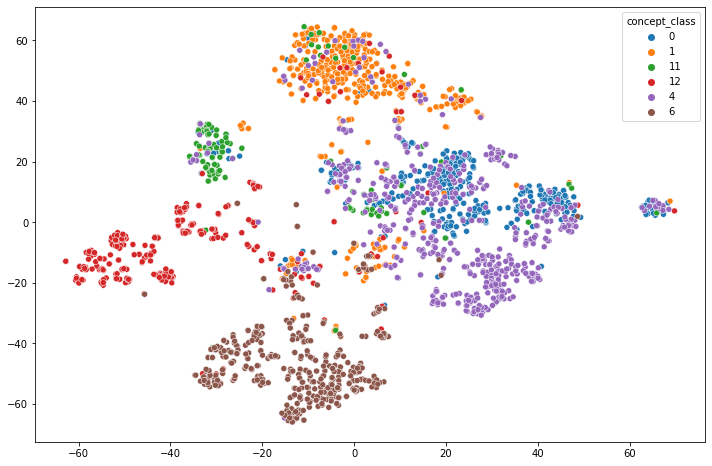

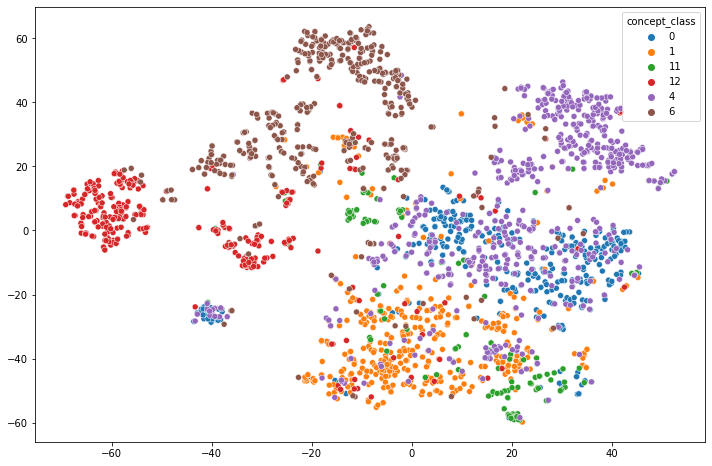

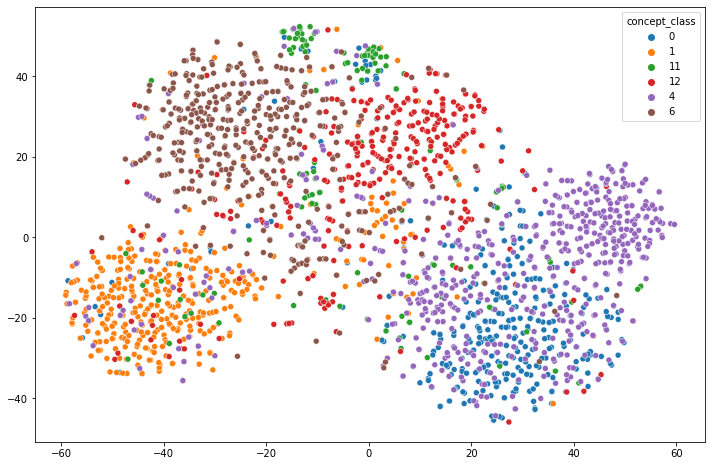

In [134]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)
X_bert_tsne = tsne.fit_transform(X_bert)
X_simkgc_tsne = tsne.fit_transform(X_simkgc)
X_transe_tsne = tsne.fit_transform(X_transe)

plt.figure(figsize=(12,8))
sns.scatterplot(x=X_bert_tsne[:,0], y=X_bert_tsne[:,1], hue=df_ent_info_sampled["concept_class"])
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_simkgc_tsne[:,0], y=X_simkgc_tsne[:,1], hue=df_ent_info_sampled["concept_class"])
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_transe_tsne[:,0], y=X_transe_tsne[:,1], hue=df_ent_info_sampled["concept_class"])